## Import Libraries

In [ ]:
#!pip install cufflinks
#!pip install dash dash-bootstrap-components pandas numpy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cufflinks as cf
cf.go_offline()
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# EXPLORATORY DATA ANALYSIS (EDA) & VISUALIZATION

## 1. Read, Inspect, and Cleaning Data

In [3]:
def read_inspect_data(path):
    df = pd.read_csv(path)
    print("First 5 rows of the dataset:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe().T)
    print("\nDescriptive statistics for object (categorical) columns:")
    print(df.describe(include='object').T)
    print("\nNumber of duplicated rows:")
    print(df.duplicated().sum())
    print("\nNumber of missing values in each column:")
    print(df.isna().mean())
    print("\nNumber of unique values in each column:")
    print(df.nunique())
    return df

stroke = read_inspect_data('healthcare-dataset-stroke-data.csv')

First 5 rows of the dataset:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

DataFrame Info:
<class 'pa

The column of 'Residence_type' begins with uppercase while others are not. To make a standardize grammer to prevent mistake we will change all column names into lowercase

In [4]:
stroke.columns = stroke.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

In [5]:
pd.DataFrame({'Null Count': stroke.isnull().sum(), 
                          'Null Percentage %': stroke.isnull().mean()*100}).sort_values(by='Null Percentage %', ascending=False).T

,bmi,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,smoking_status,stroke
Null Count,201.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Null Percentage %,3.933464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the given dataset, there have been 201 missing values in the column of "bmi". These missing values will be handled with after Train & Split process for preventing data leakage.

• In this dataset, target variable is coded as 1 for positive cases (having stroke) and 0 for negative cases (not having stroke).

• Both Hypertension and heart disease have integer data types, not as an object.

• Like our Target variable (stroke), both hypertension and heart_disease are coded as 1 for the positive cases and 0 for negative cases.

<Axes: >

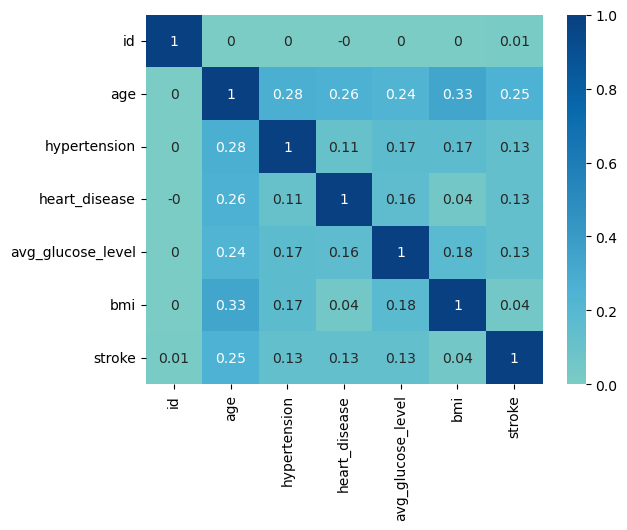

In [6]:
sns.heatmap(round(stroke.corr(numeric_only=True), 2), annot=True, cmap='GnBu', center=0)

In [7]:
stroke.quantile([0, 0.1, 0.25, 0.9, 0.95, 0.99, 0.999, 1], numeric_only=True).T

,0.000,0.100,0.250,0.900,0.950,0.990,0.999,1.000
id,67.00,6972.500,17741.250,65667.600,69217.9500,72264.6700,72880.36500,72940.00
age,0.08,11.000,25.000,75.000,79.0000,82.0000,82.00000,82.00
hypertension,0.00,0.000,0.000,0.000,1.0000,1.0000,1.00000,1.00
heart_disease,0.00,0.000,0.000,0.000,1.0000,1.0000,1.00000,1.00
avg_glucose_level,55.12,65.789,77.245,192.181,216.2945,240.7082,263.53384,271.74
bmi,10.30,19.700,23.500,38.900,42.9600,53.4000,64.98400,97.60
stroke,0.00,0.000,0.000,0.000,0.0000,1.0000,1.00000,1.00


In [8]:
numerical= stroke.drop(['stroke'], axis=1).select_dtypes('number').columns

categorical = stroke.select_dtypes('object').columns

print("\033[1m", "Numerical Columns:", "\033[0;0m",  numerical)
print("------------------------------------------------------------------------------------------------------------------")
print("\033[1m", "Categorical Columns:", "\033[0;0m", categorical)

 Numerical Columns:  Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi'],
      dtype='object')
------------------------------------------------------------------------------------------------------------------
 Categorical Columns:  Index(['gender', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')


## 2. Visualize Key Features

In [9]:
def count_plot(data, col, hue):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.countplot(data=data, x=col, ax=axes[0])
    axes[0].set_title(f'Count of {col}')
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].text(p.get_x() + p.get_width() / 2., height + 0.1,
                    f'{int(height)}',
                    ha='center', va='bottom')


    sns.countplot(data=data, x=col, hue=hue, ax=axes[1])
    axes[1].set_title(f'{col} vs. {hue}')
    for p in axes[1].patches:
        height = p.get_height()
        if height > 0:
            axes[1].text(p.get_x() + p.get_width() / 2., height + 0.1,
                        f'{int(height)}',
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


    print('Unique values\n', data[col].unique())
    print('Value Counts\n', data[col].value_counts())


def distribution(data, col1, col2):
    print(f"Number of unique {col1}: {data[col1].nunique()}")

    # Distribution plot of {col1}
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col1], kde=True)
    plt.title(f'Distribution of {col1}')
    plt.xlabel(f'{col1}')
    plt.ylabel('Frequency')
    plt.show()

    # Box plot of {col1} vs. stroke
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, x=col2, y=col1)
    plt.title(f'{col1} Distribution by {col2} Outcome')
    plt.xlabel('Stroke (0: No Stroke, 1: Stroke)')
    plt.ylabel(f'{col1}')
    plt.xticks([0, 1], ['No Stroke', 'Stroke'])  # Improve x-axis labels
    plt.grid(True, axis='y', linestyle='--')  # Add a subtle grid for better readability
    plt.show()

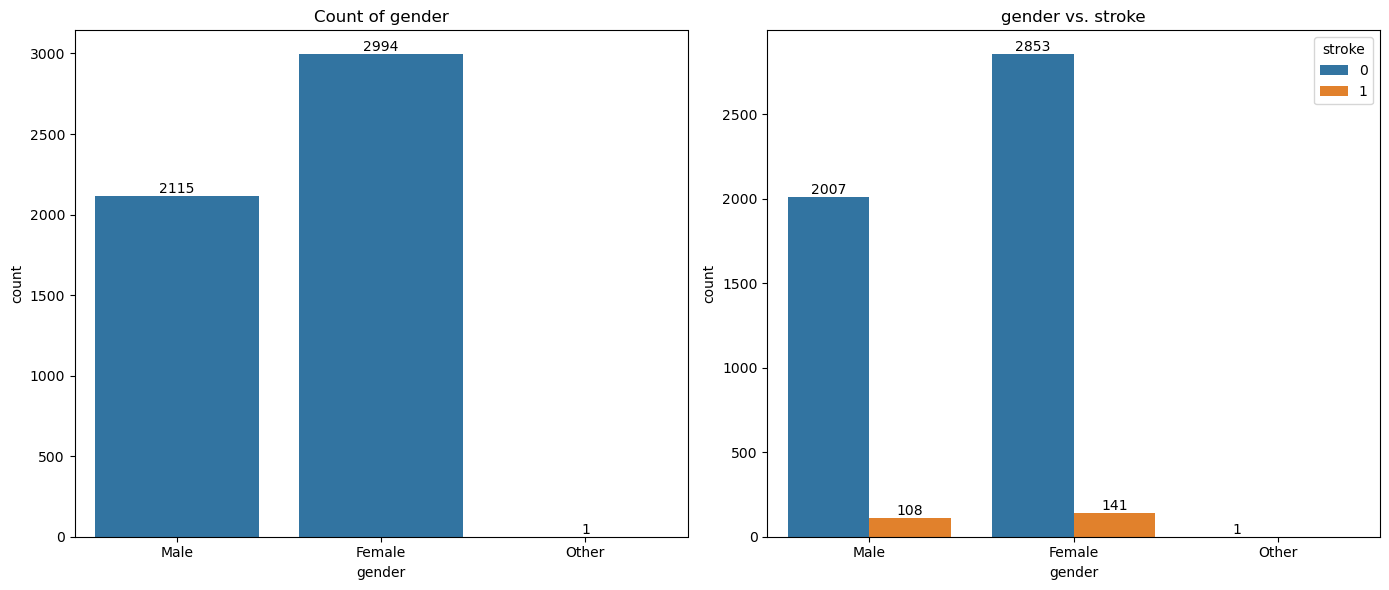

Unique values
 ['Male' 'Female' 'Other']
Value Counts
 gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
Number of unique age: 104


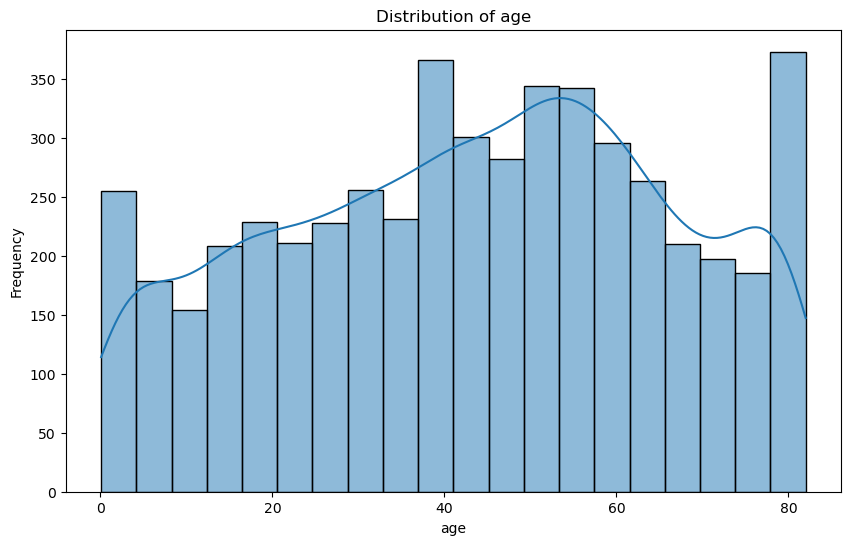

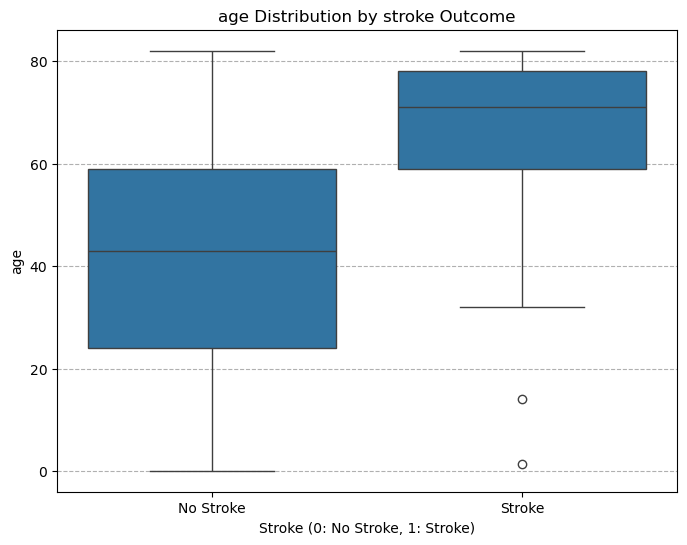

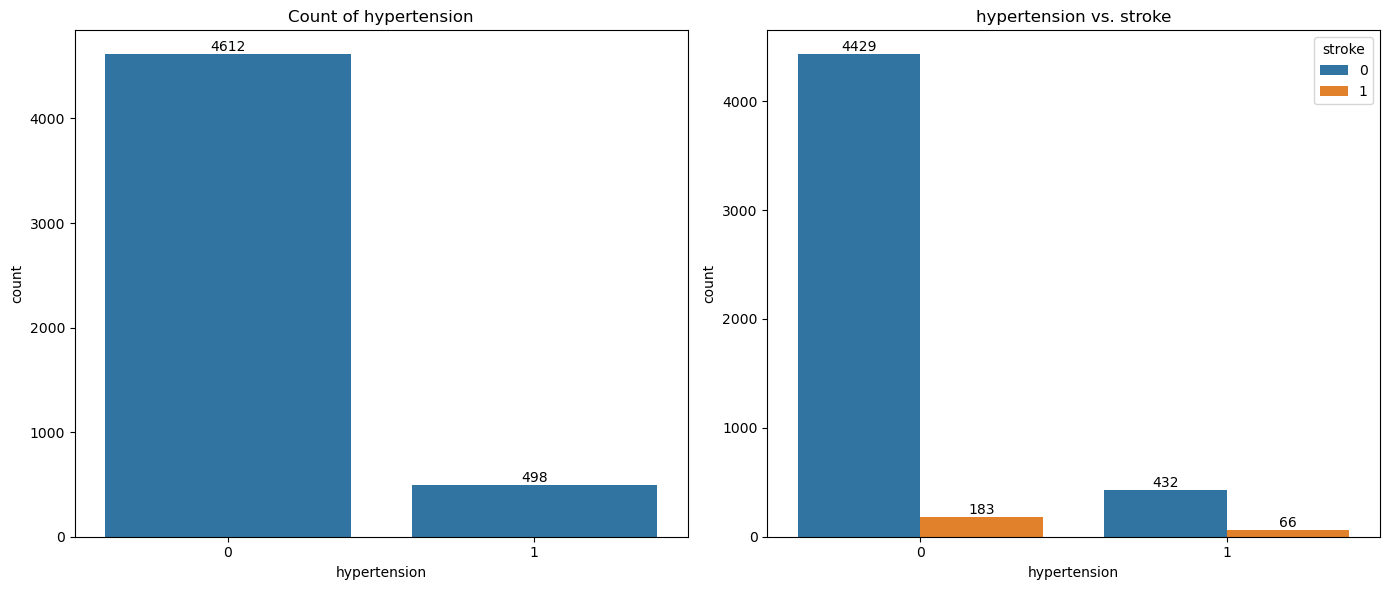

Unique values
 [0 1]
Value Counts
 hypertension
0    4612
1     498
Name: count, dtype: int64


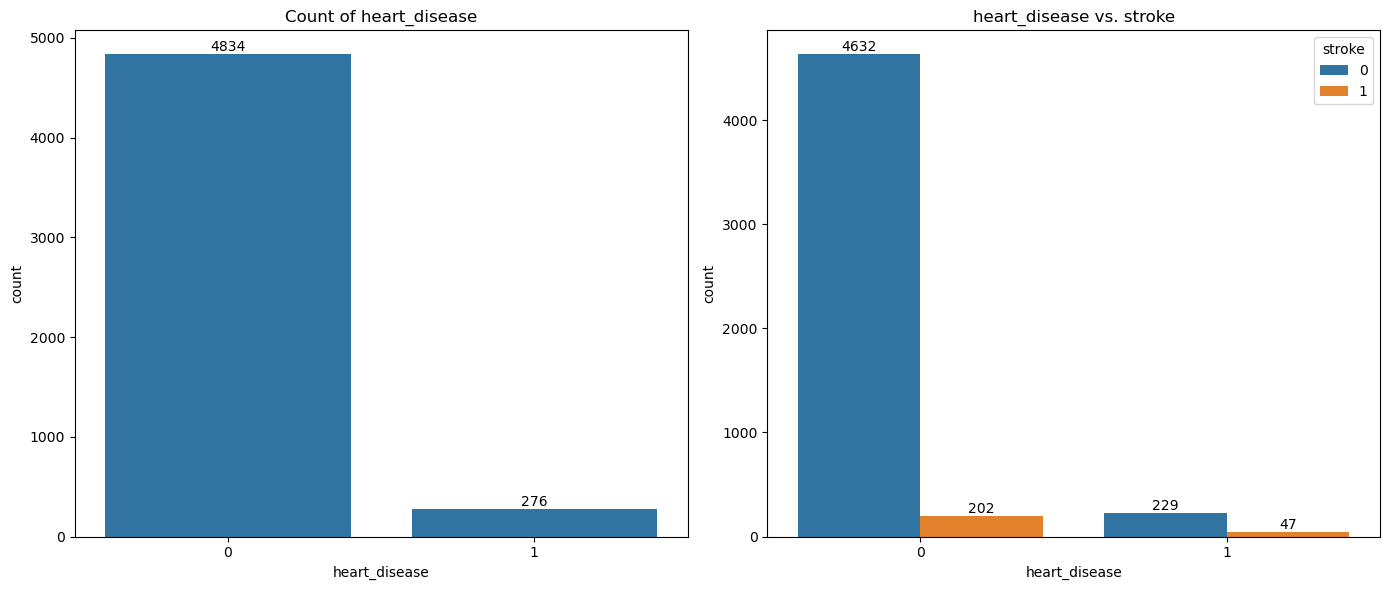

Unique values
 [1 0]
Value Counts
 heart_disease
0    4834
1     276
Name: count, dtype: int64


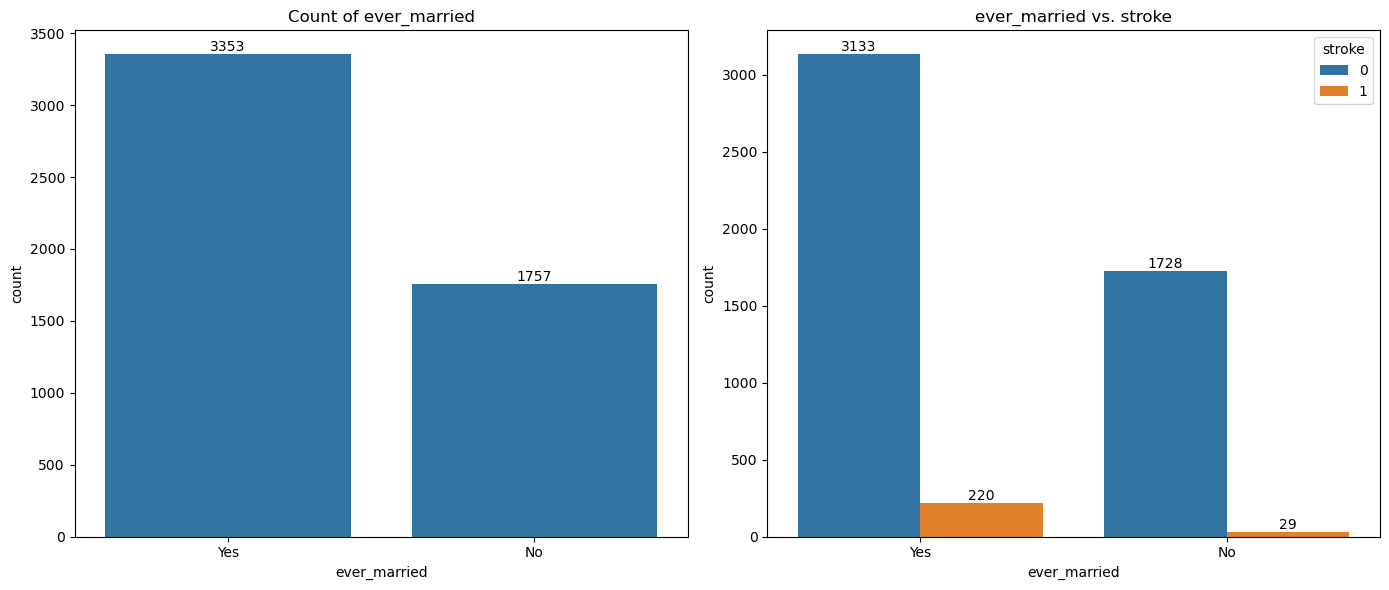

Unique values
 ['Yes' 'No']
Value Counts
 ever_married
Yes    3353
No     1757
Name: count, dtype: int64


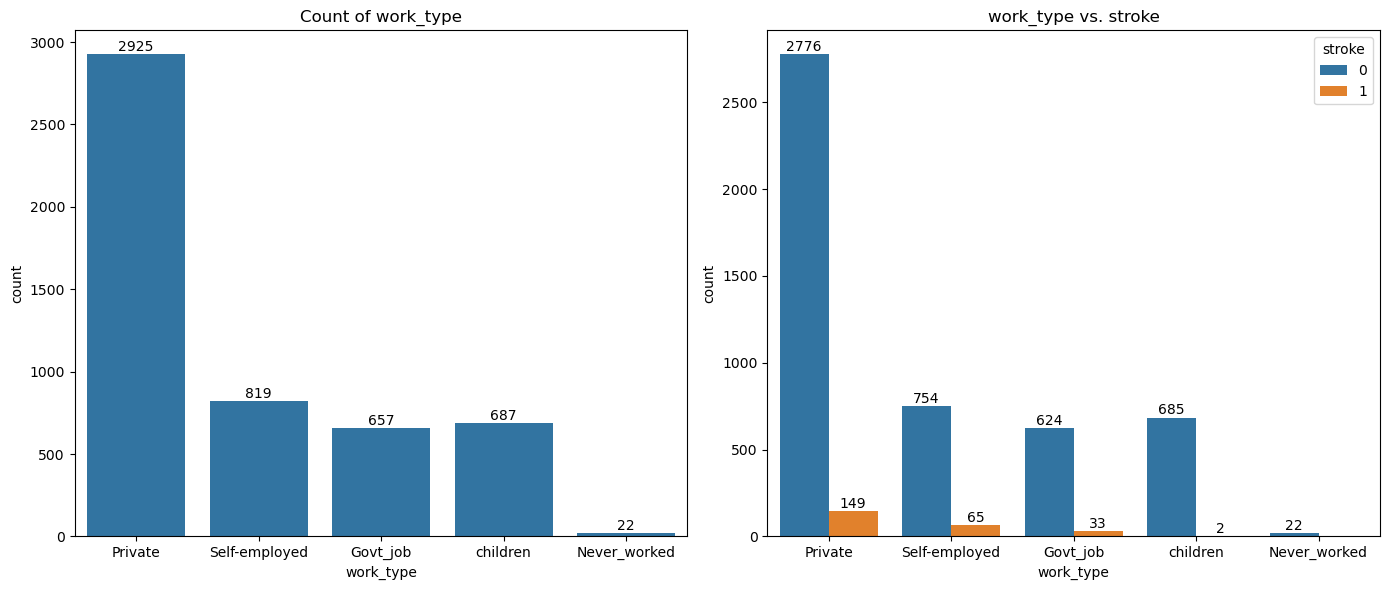

Unique values
 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Value Counts
 work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


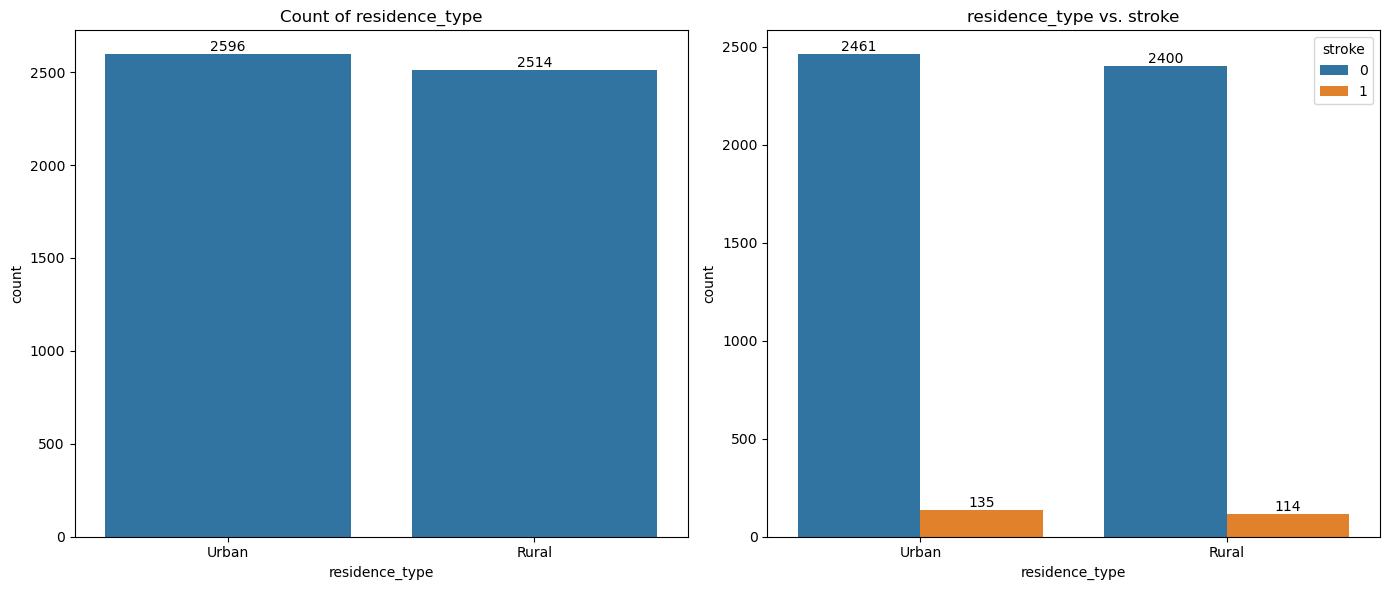

Unique values
 ['Urban' 'Rural']
Value Counts
 residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


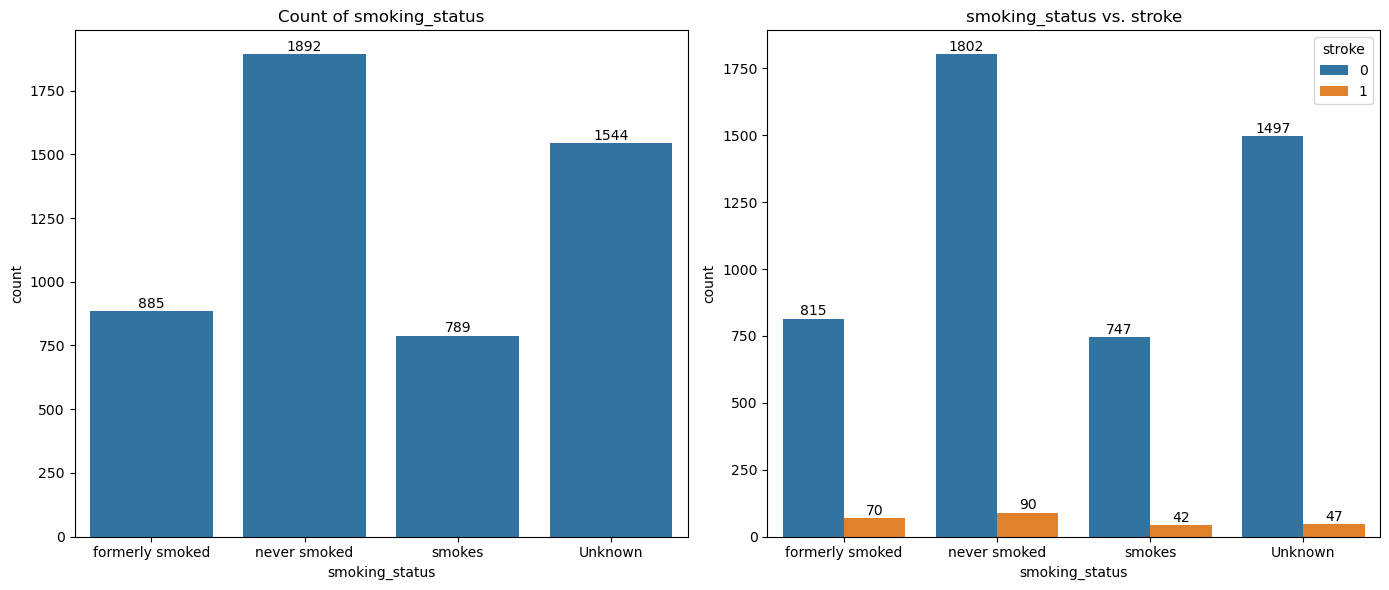

Unique values
 ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
Value Counts
 smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
Number of unique avg_glucose_level: 3979


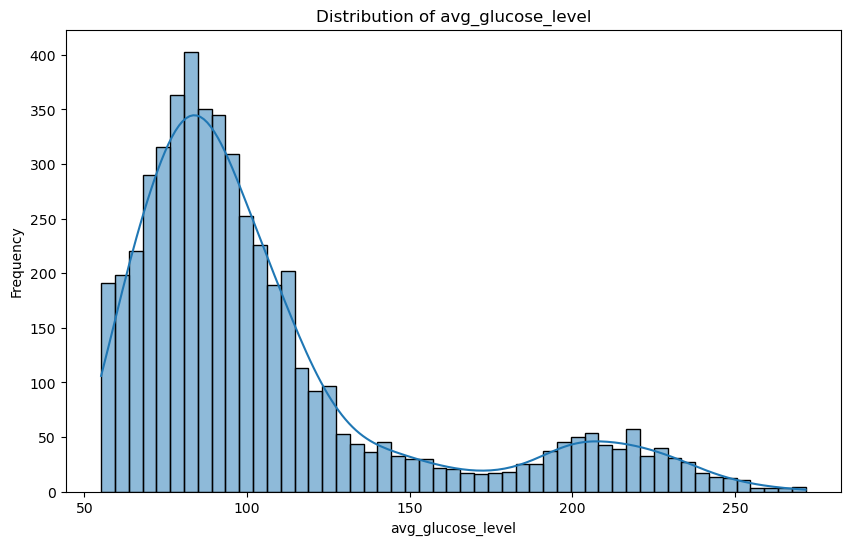

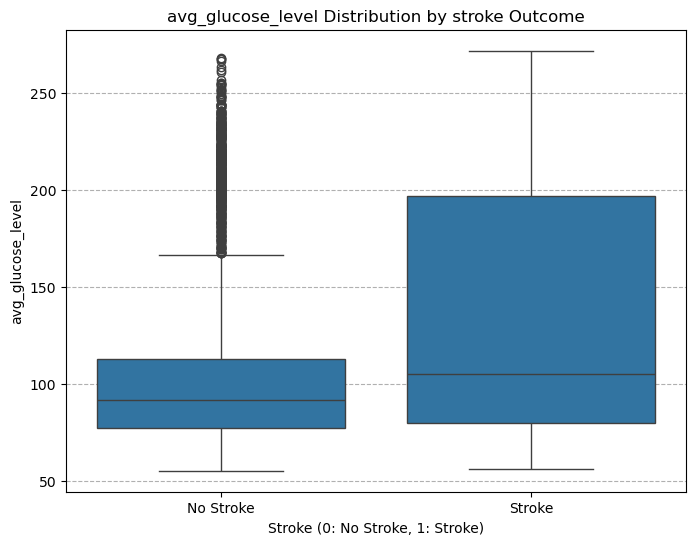

Number of unique bmi: 418


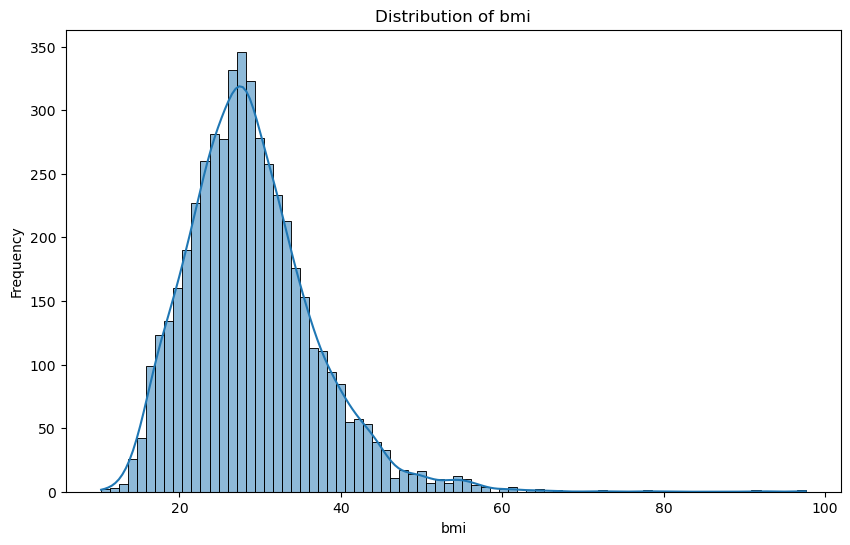

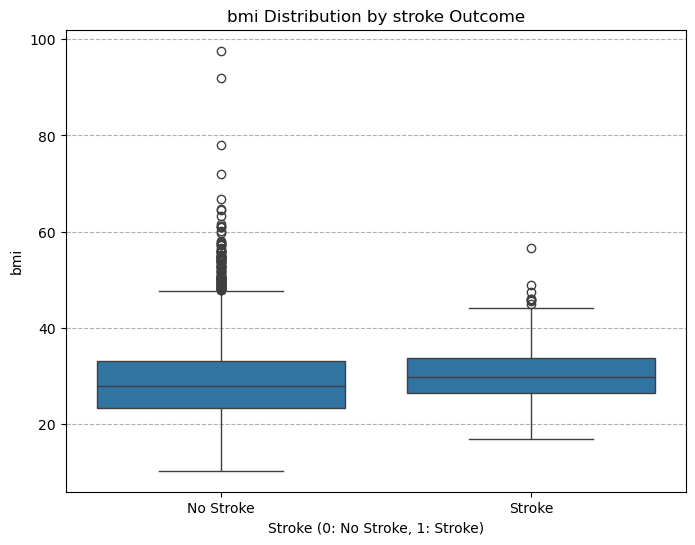

In [10]:
count_plot(stroke, 'gender', 'stroke')
distribution(stroke, 'age', 'stroke')
count_plot(stroke,'hypertension', 'stroke')
count_plot(stroke, 'heart_disease', 'stroke')
count_plot(stroke, 'ever_married', 'stroke')
count_plot(stroke, 'work_type', 'stroke')
count_plot(stroke, 'residence_type', 'stroke')
count_plot(stroke, 'smoking_status', 'stroke')
distribution(stroke, 'avg_glucose_level', 'stroke')
distribution(stroke, 'bmi', 'stroke')

**A. Distribution of Strokes (Target Variable)**

The proportion of target variable is one of the most important things in a classification problem. So let's a close look at how its values are distributed.

Percentage of patient has a stroke: % 4.87 -->     (249 patient)
Percentage of patient does not have a stroke: % 95.13 -->       (4861 patient)


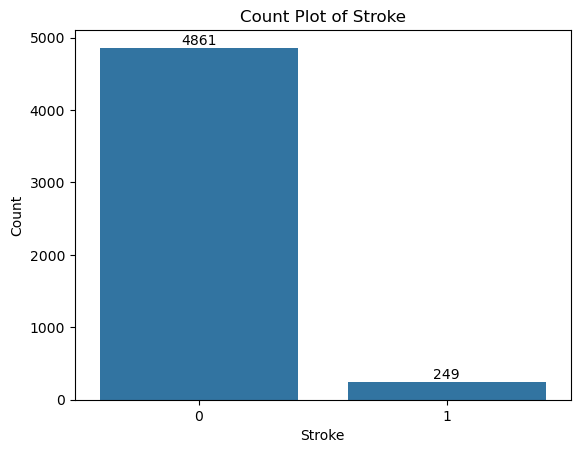

In [11]:
target = stroke['stroke']
print(f'Percentage of patient has a stroke: % {round(target.value_counts(normalize=True)[1]*100,2)} -->\
     ({target.value_counts()[1]} patient)\nPercentage of patient does not have a stroke: % {round(target.value_counts(normalize=True)[0]*100,2)} -->\
       ({target.value_counts()[0]} patient)')

ax = sns.countplot(data=stroke, x='stroke')

# Iterate through the bars and add the count
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            f'{int(height)}',
            ha='center', va='bottom')

plt.title('Count Plot of Stroke')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

In this sense, almost %95 of the instances in our target variable haven't experienced with 'stroke' representing 4861 patients.

On the other hand %5 of the instances in our target variable go through 'Stroke' representing 249 patient.

Similarly, it's clear that the proportinate distribution for each class is not the case here. So we should assume an imbalanced data we have in the given case.

Helps check if the dataset is imbalanced (usually, stroke cases are rare).

In [12]:
stroke[stroke['stroke']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
id,4861.000000,36487.236371,21120.133386,67.000000,17762.000000,36958.000000,54497.000000,72940.000000
age,4861.000000,41.971545,22.291940,0.080000,24.000000,43.000000,59.000000,82.000000
hypertension,4861.000000,0.088871,0.284586,0.000000,0.000000,0.000000,0.000000,1.000000
heart_disease,4861.000000,0.047110,0.211895,0.000000,0.000000,0.000000,0.000000,1.000000
avg_glucose_level,4861.000000,104.795513,43.846069,55.120000,77.120000,91.470000,112.830000,267.760000
bmi,4700.000000,28.823064,7.908287,10.300000,23.400000,28.000000,33.100000,97.600000
stroke,4861.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


**B. Numerical Features**

In [13]:
stroke[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60


In [14]:
stroke[numerical].iplot(kind='histogram', subplots=True, bins=50)

In [15]:
for i in stroke[numerical].drop(columns=['id','hypertension', 'heart_disease']).columns:
    stroke[i].iplot(kind="box", title=i, boxpoints="all",color='Blue')

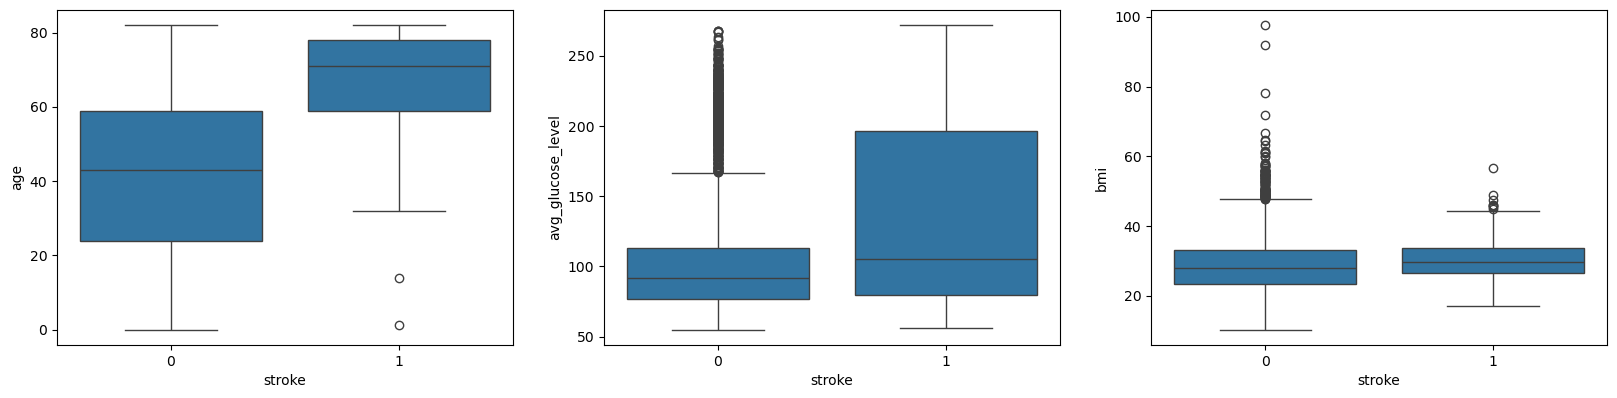

In [16]:
index = 0
plt.figure(figsize=(20,20))
for feature in stroke[numerical].drop(columns=['id','hypertension', 'heart_disease']).columns:
    if feature != "stroke":
        index += 1
        plt.subplot(4,3,index)
        sns.boxplot(x='stroke', y=feature, data=stroke)

**Handle Weired Type in Gender *'Other'* By drop it**

In the "gender" column there has been an undefined classification which makes no contribution to understand stroke. So let's discard this row from the analysis.

In [17]:
stroke.drop(stroke[stroke['gender'] == 'Other'].index, inplace=True)
stroke.drop(columns=['id'], inplace=True)
stroke.shape

(5109, 11)

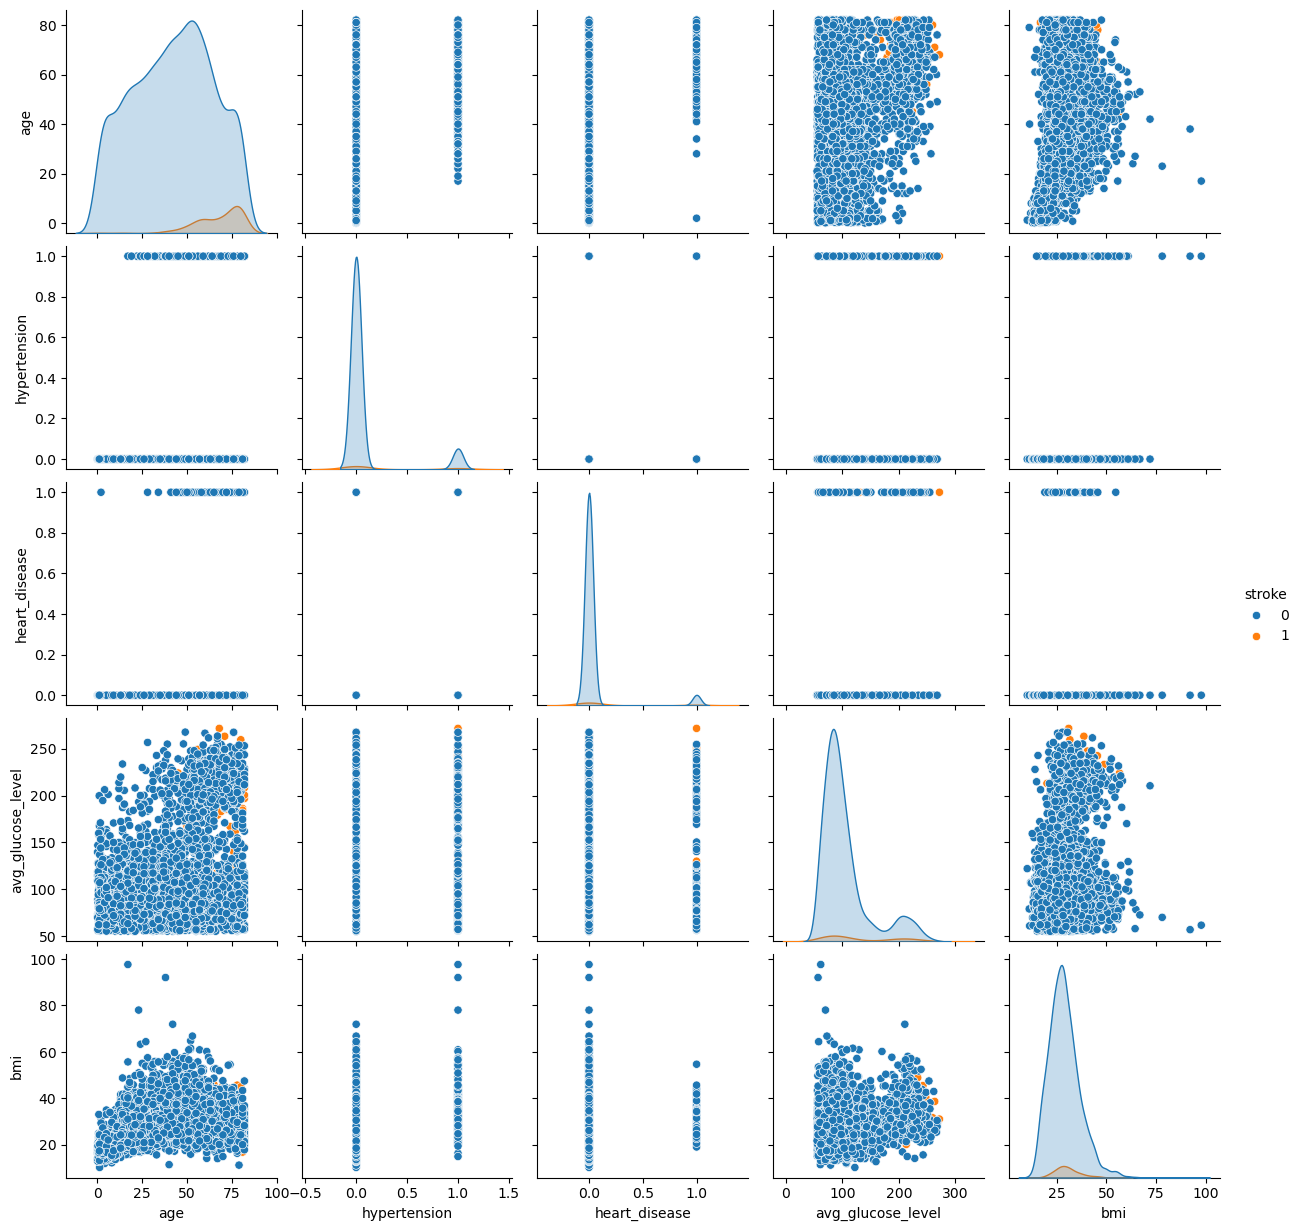

In [18]:
sns.pairplot(stroke, hue="stroke")

### Feature Engineering

In [19]:
stroke_visualize = stroke.copy()

In [20]:
stroke_visualize['bmi'] = stroke_visualize['bmi'].transform(lambda x: x.fillna(x.median()))

In [21]:
stroke_visualize.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [22]:
# Age Groups
stroke_visualize['age_group'] = pd.cut(stroke_visualize['age'], bins=[0,15,25,65,100], 
                                  labels=['Children (00-14 years)', 'Youth (15-24 years)', 'Adults (25-64 years)', 'Seniors (65 years and over)'])

# Glucose level categories
stroke_visualize['glucose_category'] = pd.cut(stroke_visualize['avg_glucose_level'], 
                                         bins=[0, 70, 99, 125, float('inf')], 
                                         labels=['Low', 'Normal', 'Prediabetes', 'Diabetes'])

# BMI Categories
stroke_visualize['bmi_category'] = pd.cut(stroke_visualize['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')], 
                                     labels=['Underweight', 'Normal weight', 'Overweight','Obese'])

**B. Age vs. Stroke**

**Does age significantly affect stroke risk?**

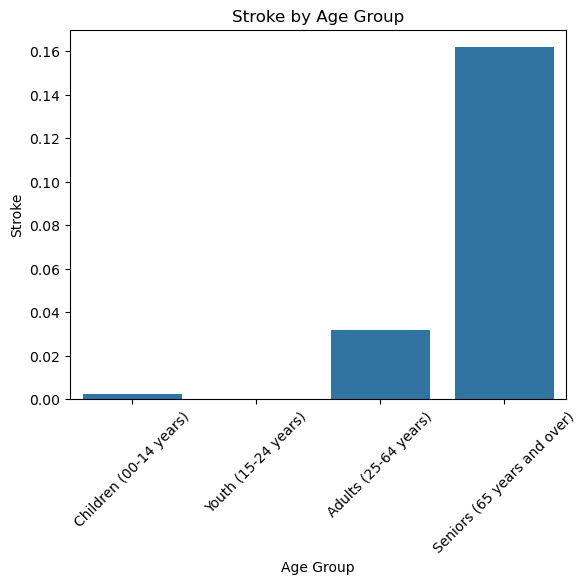

In [23]:
sns.barplot(data=stroke_visualize, x='age_group', y='stroke', errorbar=None)
plt.xticks(rotation=45)
plt.title('Stroke by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Stroke')
plt.show()

Older patients tend to have higher stroke risk.

**C. Glucose Levels & BMI Analysis**

**Are high glucose levels linked to higher stroke risk?**

**Does BMI (Body Mass Index) influence stroke likelihood?**

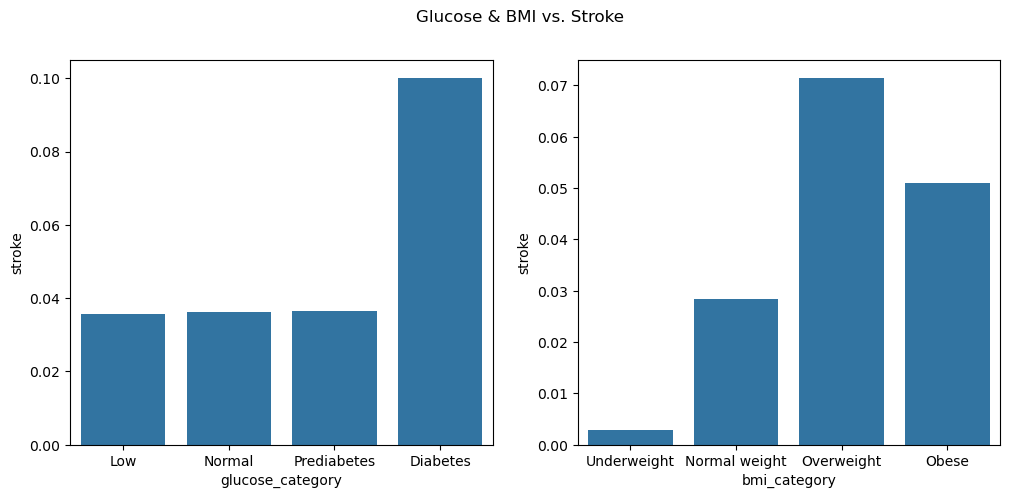

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(y='stroke', x='glucose_category', data=stroke_visualize, ax=axes[0], errorbar=None)
sns.barplot(y='stroke', x='bmi_category', data=stroke_visualize, ax=axes[1], errorbar=None)
plt.suptitle("Glucose & BMI vs. Stroke")
plt.show()

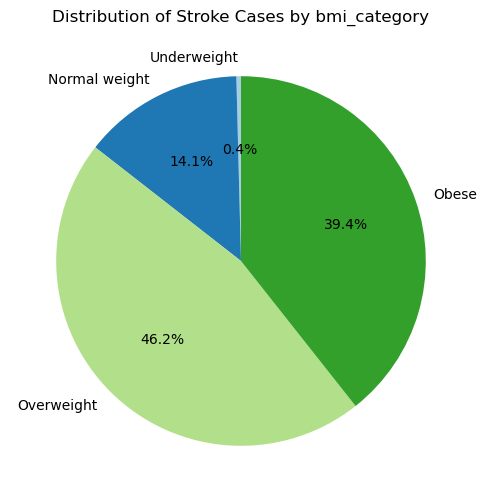

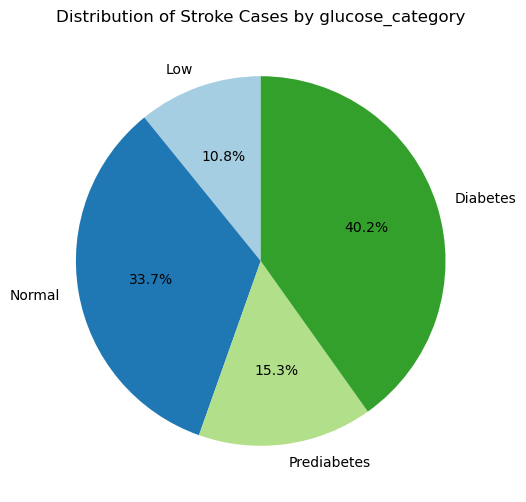

In [25]:
cat_features = ['bmi_category', 'glucose_category']
for feature in cat_features:
    # Group the data by the feature and stroke status
    data = stroke_visualize.groupby([feature, 'stroke']).size().unstack()

    # Create pie chart for stroke = 1 (stroke cases)
    plt.figure(figsize=(8, 6))
    plt.pie(data.loc[:, 1], labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(f"Distribution of Stroke Cases by {feature}")
    plt.ylabel("")  # Remove default ylabel
    plt.show()

High glucose levels may correlate with stroke risk.

**D. Hypertension & Heart Disease Impact**

**How do hypertension and heart disease relate to stroke?**

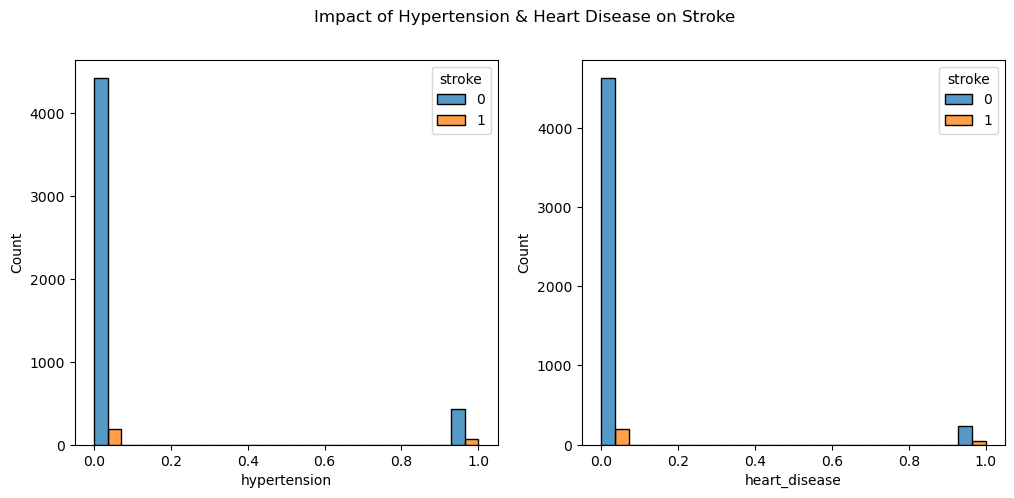

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(x='hypertension', hue='stroke', data=stroke_visualize, ax=axes[0], multiple='dodge')
sns.histplot(x='heart_disease', hue='stroke', data=stroke_visualize, ax=axes[1], multiple='dodge')
plt.suptitle("Impact of Hypertension & Heart Disease on Stroke")
plt.show()

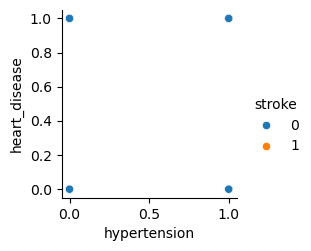

In [27]:
sns.pairplot(data=stroke_visualize, hue='stroke', x_vars='hypertension', y_vars='heart_disease')

Patients with hypertension or heart disease may have a higher stroke risk.

**E. Categorical Features (Gender, Smoking, Work Type, Residence Type, Martial Status)**

**Is gender a strong predictor of stroke?**

**Does smoking status (current/former/never) impact stroke probability?**

**Do certain work types (private, self-employed, govt jobs) have different stroke risks?**

**Are married individuals more/less likely to have strokes?**

**Do urban/rural residents have different stroke rates?**

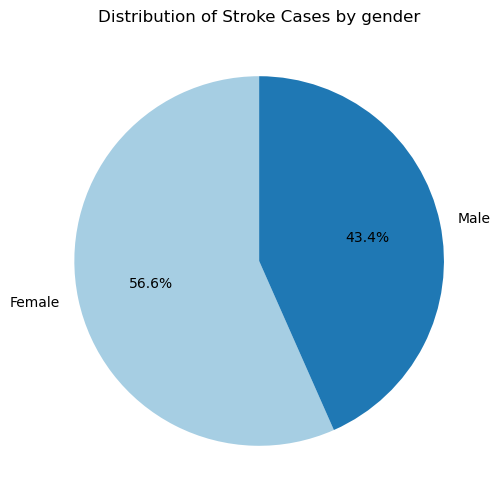

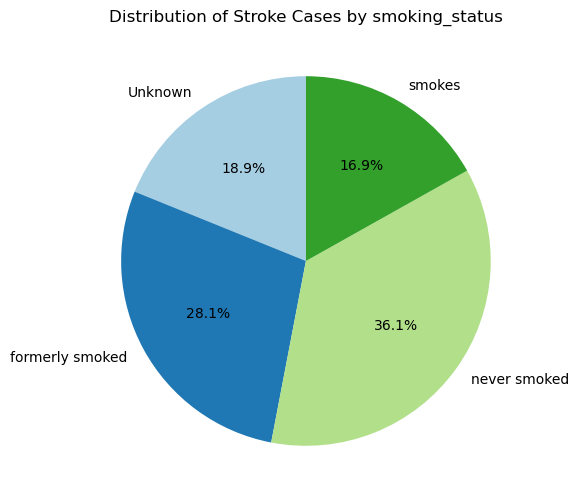

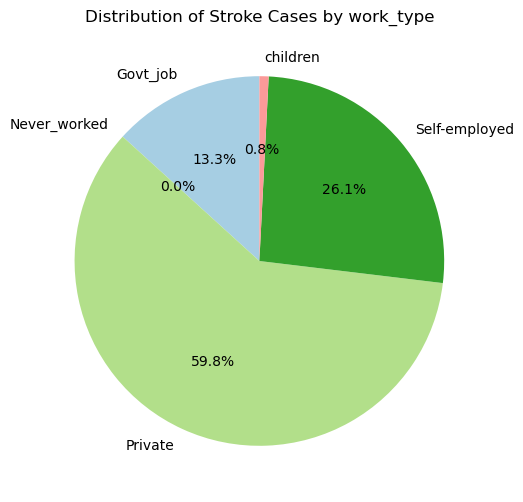

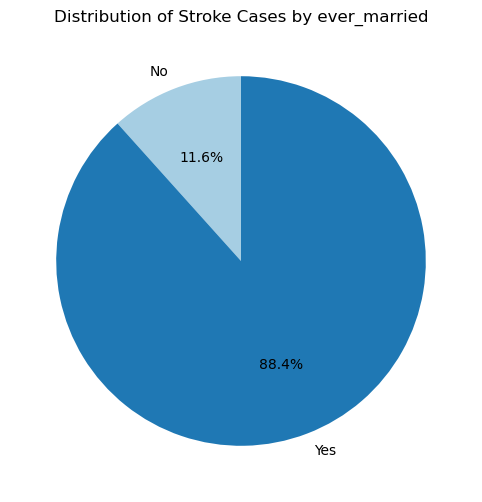

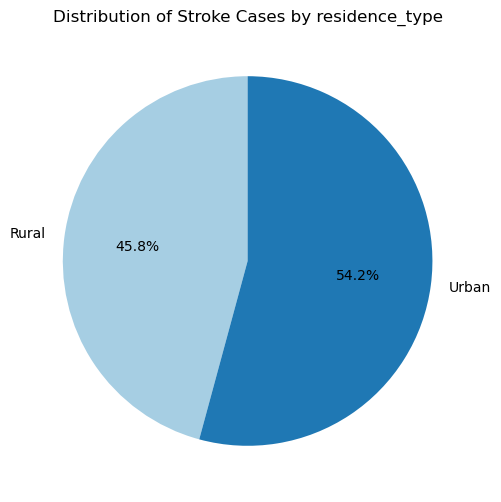

In [28]:
cat_features = ['gender', 'smoking_status', 'work_type', 'ever_married', 'residence_type']
for feature in cat_features:
    # Group the data by the feature and stroke status
    data = stroke_visualize.groupby([feature, 'stroke']).size().unstack()
    data.loc[:, 1] = data.loc[:, 1].fillna(0)  # Handle NaN values

    # Create pie chart for stroke = 1 (stroke cases)
    plt.figure(figsize=(8, 6))
    plt.pie(data.loc[:, 1], labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(f"Distribution of Stroke Cases by {feature}")
    plt.ylabel("")  # Remove default ylabel
    plt.show()

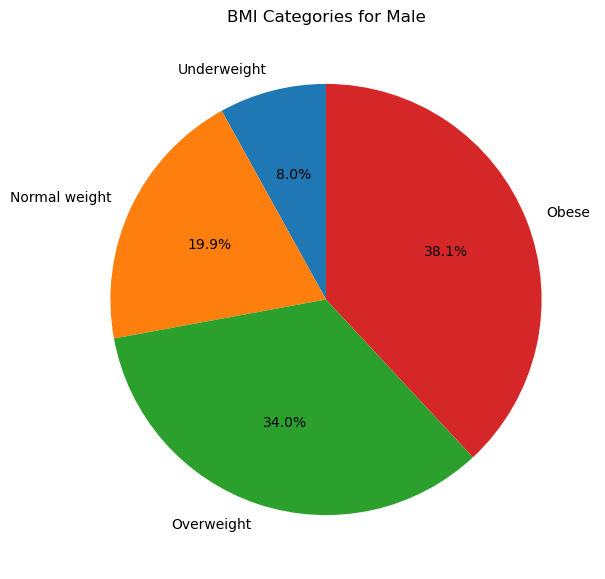

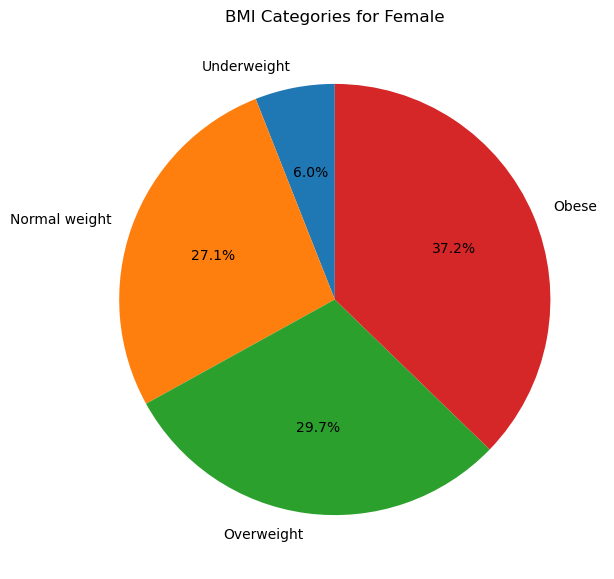

In [29]:
# Group by gender and BMI category to get the count of each category
bmi_by_gender = stroke_visualize.groupby(['gender', 'bmi_category']).size().unstack()

# Plot a pie chart for each gender
gender_list = stroke_visualize['gender'].unique()
for gender in gender_list:
    plt.figure(figsize=(7, 7))
    bmi_by_gender.loc[gender].plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)
    plt.title(f'BMI Categories for {gender}')
    plt.ylabel('')  # Remove the y-axis label
    plt.show()

**Is there a relationship between gender and bmi?**

In [30]:
# Descriptive statistics for BMI by gender
bmi_by_gender = stroke_visualize.groupby('gender')['bmi'].describe()
print(bmi_by_gender)

         count       mean       std   min     25%   50%   75%   max
gender                                                             
Female  2994.0  29.034469  7.980102  10.3  23.425  28.1  33.3  78.0
Male    2115.0  28.620993  7.279531  11.5  24.250  28.1  32.2  97.6


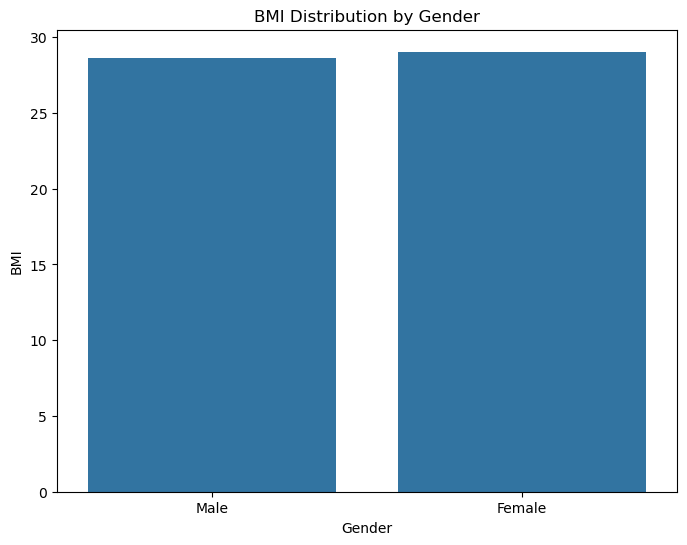

In [31]:
plt.figure(figsize=(8, 6))
sns.barplot(data=stroke_visualize, x='gender', y='bmi', errorbar=None)
plt.title('BMI Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('BMI')
plt.show()

**Is bmi affected by age?**

In [32]:
# Calculate the correlation between age and BMI
correlation = stroke_visualize[['age', 'bmi']].corr().iloc[0, 1]
print(f"Correlation between Age and BMI: {correlation}")

Correlation between Age and BMI: 0.3242113016766694


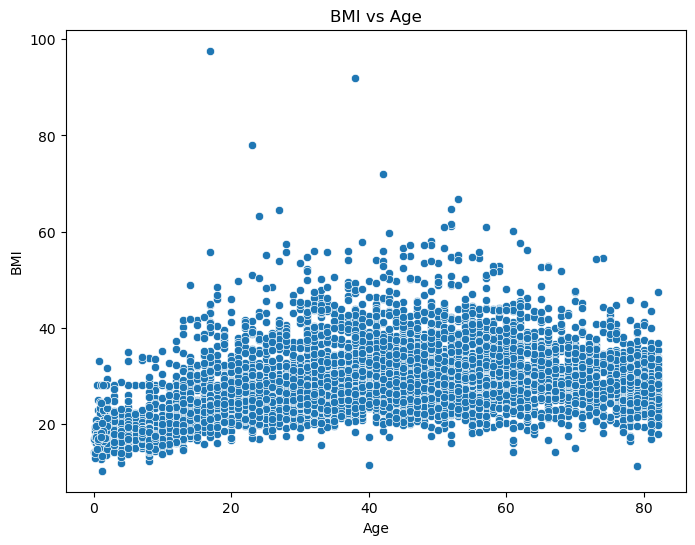

In [33]:
# Scatter plot with age on the x-axis and BMI on the y-axis
plt.figure(figsize=(8, 6))
sns.scatterplot(data=stroke_visualize, x='age', y='bmi')
plt.title('BMI vs Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

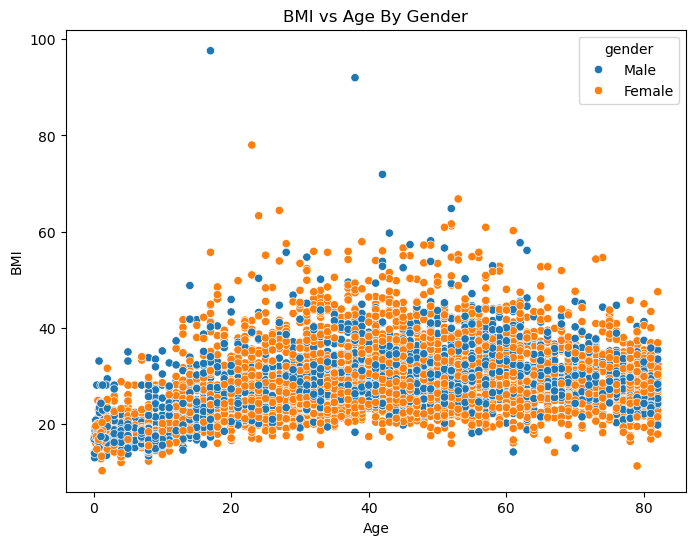

In [34]:
# Scatter plot with age on the x-axis and BMI on the y-axis grouped by gender
plt.figure(figsize=(8, 6))
sns.scatterplot(data=stroke_visualize, x='age', y='bmi', hue='gender')
plt.title('BMI vs Age By Gender')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

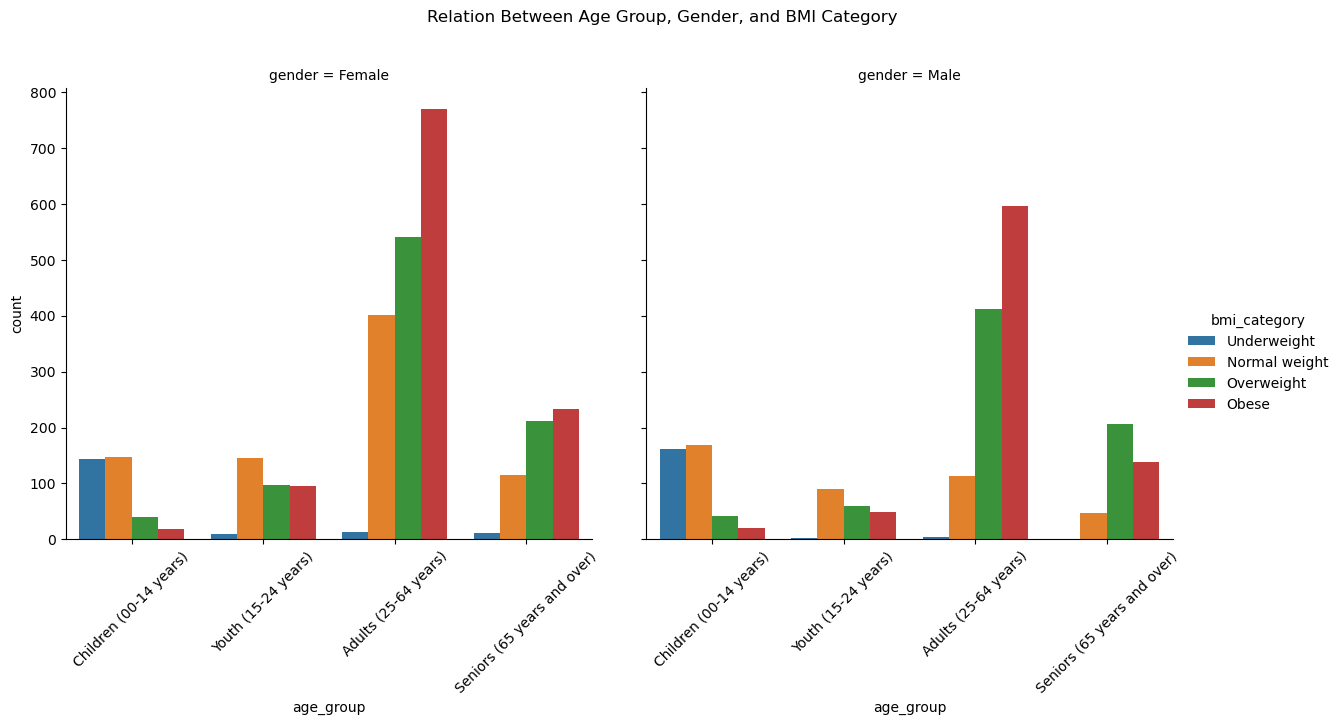

In [35]:
# Group data by age group, gender, and BMI category
grouped_data = stroke_visualize.groupby(['age_group', 'gender', 'bmi_category']).size().reset_index(name='count')

cat_plot = sns.catplot(data=grouped_data, x='age_group', y='count', hue='bmi_category', col='gender', kind='bar', errorbar=None, height=6, aspect=1)
cat_plot.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
plt.suptitle("Relation Between Age Group, Gender, and BMI Category")
plt.show()

# Machine Learning

## Label Encoder Operation

Label Encoding refers to converting the labels into a numeric form so as to convert them into the machine-readable form. Machine learning algorithms can then decide in a better way how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.

• we have 5 categorical variables, which needs to be converted to Label Encoder.

In [36]:
stroke_labeled = stroke.copy()

In [37]:
stroke_labeled.drop(['age_group', 'glucose_category', 'bmi_category'], axis=1, inplace=True)
stroke_labeled.sample()

KeyError: "['age_group', 'glucose_category', 'bmi_category'] not found in axis"

In [ ]:
# Preprocessing for categorical features
le=LabelEncoder()
objList = stroke_labeled.select_dtypes(include = "object").columns # only columns with object datatypes
print (objList)

for i in objList:
    stroke_labeled[i] = le.fit_transform(stroke_labeled[i].astype(str))

print (stroke_labeled.info())

Index(['gender', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int32  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int32  
 5   work_type          5109 non-null   int32  
 6   residence_type     5109 non-null   int32  
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   int32  
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int32(5), int64(3)
memory usage: 379.2 KB
None


In [ ]:
stroke_labeled[stroke_labeled['stroke']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
gender,4860.000000,0.412963,0.492417,0.000000,0.000000,0.000000,1.000000,1.000000
age,4860.000000,41.974831,22.293056,0.080000,24.000000,43.000000,59.000000,82.000000
hypertension,4860.000000,0.088889,0.284613,0.000000,0.000000,0.000000,0.000000,1.000000
heart_disease,4860.000000,0.047119,0.211916,0.000000,0.000000,0.000000,0.000000,1.000000
ever_married,4860.000000,0.644650,0.478668,0.000000,0.000000,1.000000,1.000000,1.000000
work_type,4860.000000,2.175720,1.098366,0.000000,2.000000,2.000000,3.000000,4.000000
residence_type,4860.000000,0.506379,0.500011,0.000000,0.000000,1.000000,1.000000,1.000000
avg_glucose_level,4860.000000,104.787584,43.847095,55.120000,77.120000,91.465000,112.800000,267.760000
bmi,4699.000000,28.824431,7.908573,10.300000,23.400000,28.000000,33.100000,97.600000
smoking_status,4860.000000,1.370165,1.075564,0.000000,0.000000,2.000000,2.000000,3.000000


In [ ]:
numerical_labeled = stroke_labeled.drop(['stroke'], axis=1).select_dtypes('number').columns

categorical_labeled = stroke_labeled.select_dtypes('object').columns

print("\033[1m", "Numerical Columns:", "\033[0;0m",  numerical_labeled)
print("------------------------------------------------------------------------------------------------------------------")
print("\033[1m", "Categorical Columns:", "\033[0;0m", categorical_labeled)

 Numerical Columns:  Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')
------------------------------------------------------------------------------------------------------------------
 Categorical Columns:  Index([], dtype='object')


<Axes: >

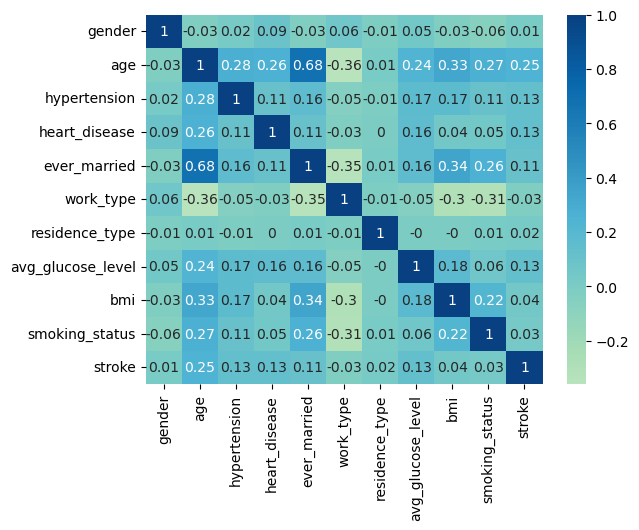

In [ ]:
sns.heatmap(round(stroke_labeled.corr(numeric_only=True), 2), annot=True, cmap='GnBu', center=0)

In [ ]:
stroke_labeled.quantile([0, 0.1, 0.25, 0.9, 0.95, 0.99, 0.999, 1], numeric_only=True)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0.000,0.0,0.08,0.0,0.0,0.0,0.0,0.0,55.12000,10.300,0.0,0.0
0.100,0.0,11.00,0.0,0.0,0.0,0.0,0.0,65.78800,19.700,0.0,0.0
0.250,0.0,25.00,0.0,0.0,0.0,2.0,0.0,77.24000,23.500,0.0,0.0
0.900,1.0,75.00,0.0,0.0,1.0,4.0,1.0,192.20200,38.900,3.0,0.0
0.950,1.0,79.00,1.0,1.0,1.0,4.0,1.0,216.30400,42.965,3.0,0.0
0.990,1.0,82.00,1.0,1.0,1.0,4.0,1.0,240.70840,53.400,3.0,1.0
0.999,1.0,82.00,1.0,1.0,1.0,4.0,1.0,263.53408,64.986,3.0,1.0
1.000,1.0,82.00,1.0,1.0,1.0,4.0,1.0,271.74000,97.600,3.0,1.0


## Data Preprocessing, Splitting, Balancing, Scaling

In [ ]:
X = stroke_labeled.drop('stroke', axis=1) # Features
y = stroke_labeled['stroke'] # Target

**Handling Missing Values *(Preprocessing)***

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputed_X = pd.DataFrame(imputer.fit_transform(X))

# Imputation removed column names; put them back
imputed_X.columns = X.columns

X = imputed_X

In [ ]:
classifier = SelectKBest(score_func=f_classif,k=5)
fits = classifier.fit(X,y)
x=pd.DataFrame(fits.scores_)
columns = pd.DataFrame(stroke_labeled.drop('stroke',axis=1).columns)
fscores = pd.concat([columns,x],axis=1)
fscores.columns = ['Attribute','Score']
fscores.sort_values(by='Score',ascending=False)

,Attribute,Score
1,age,326.799849
3,heart_disease,94.666779
7,avg_glucose_level,90.550026
2,hypertension,84.919947
4,ever_married,60.609558
8,bmi,6.655105
5,work_type,5.341306
9,smoking_status,4.037898
6,residence_type,1.213760
0,gender,0.421144


**Balancing**

In [ ]:
# Handling Imbalancing in data
# SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print the class distribution before and after SMOTE
print("Class Distribution Before SMOTE:")
print(Counter(y))
print("\nClass Distribution After SMOTE:")
print(Counter(y_resampled))

Class Distribution Before SMOTE:
Counter({0: 4860, 1: 249})

Class Distribution After SMOTE:
Counter({1: 4860, 0: 4860})
      gender        age  hypertension  heart_disease  ever_married  work_type  \
5246     0.0  57.303735           0.0            0.0           1.0        0.0   

      residence_type  avg_glucose_level        bmi  smoking_status  
5246        0.949378         110.320547  28.267137             0.0   84    1
Name: stroke, dtype: int64


**Splitting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(7776, 10) (7776,) (1944, 10) (1944,)
Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')


**Scaling**

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modeling


====== Random Forest ======
Accuracy: 0.970679012345679
F1 Score: 0.9699208443271767
AUC Score: 0.9944208525267578

Confusion Matrix:


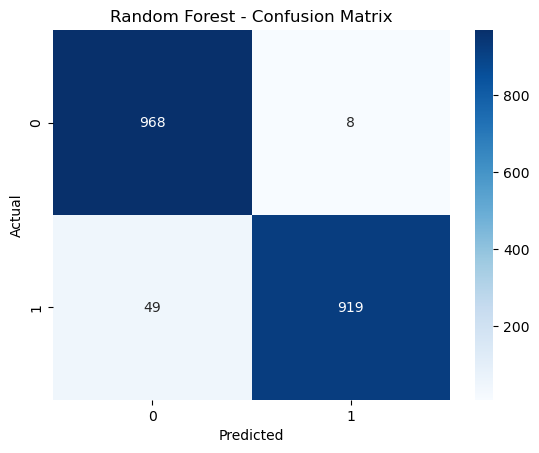


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       976
           1       0.99      0.95      0.97       968

    accuracy                           0.97      1944
   macro avg       0.97      0.97      0.97      1944
weighted avg       0.97      0.97      0.97      1944



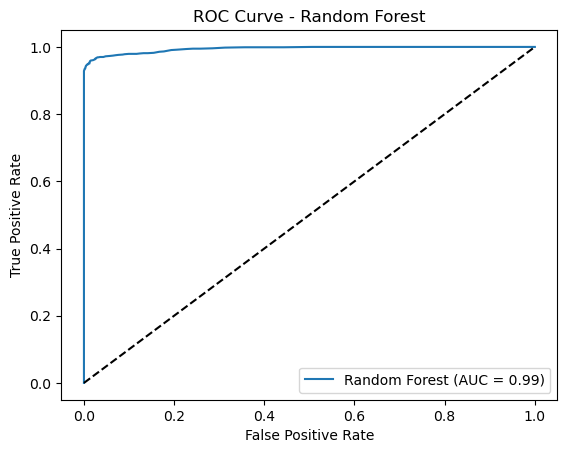


====== Logistic Regression ======
Accuracy: 0.7736625514403292
F1 Score: 0.7771023302938197
AUC Score: 0.8553687254437068

Confusion Matrix:


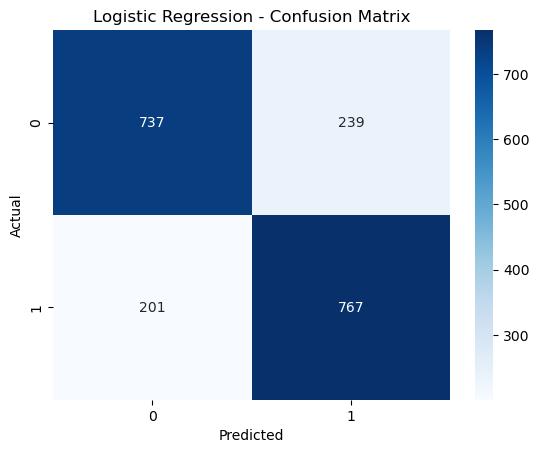


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       976
           1       0.76      0.79      0.78       968

    accuracy                           0.77      1944
   macro avg       0.77      0.77      0.77      1944
weighted avg       0.77      0.77      0.77      1944



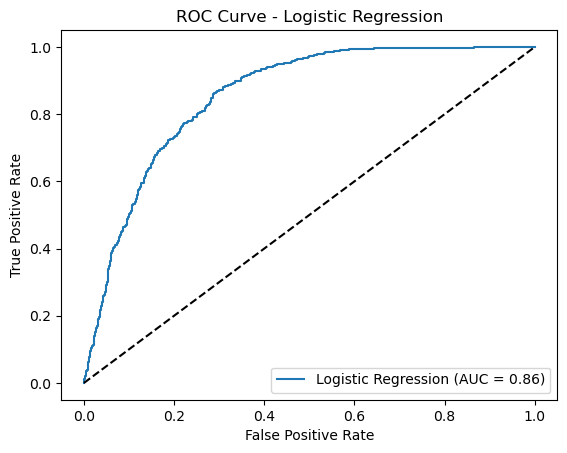


====== SVM ======
Accuracy: 0.8981481481481481
F1 Score: 0.8952380952380953
AUC Score: 0.9717470320755996

Confusion Matrix:


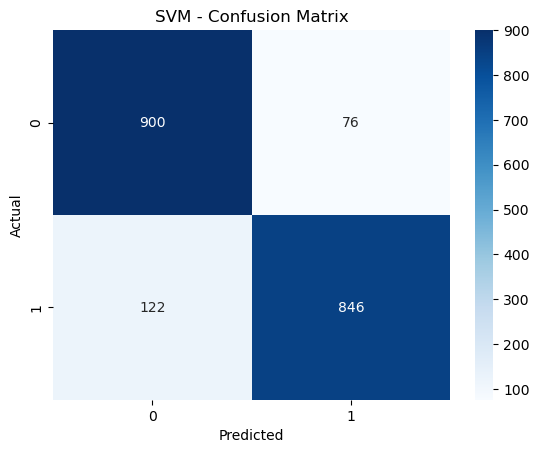


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       976
           1       0.92      0.87      0.90       968

    accuracy                           0.90      1944
   macro avg       0.90      0.90      0.90      1944
weighted avg       0.90      0.90      0.90      1944



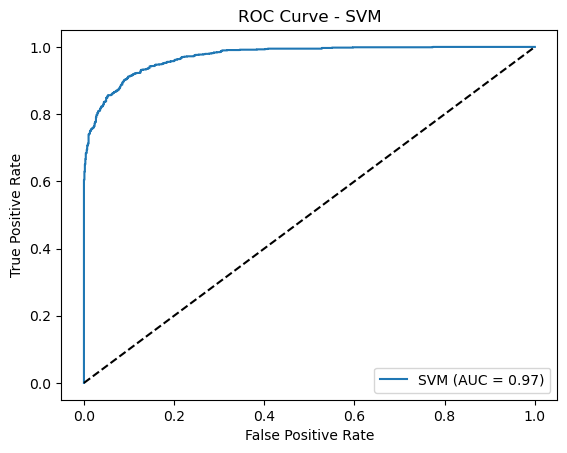

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', kernel='rbf', random_state=42)
}
# Add feature names during model training
feature_names = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 
                 'work_type', 'residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
X_train = pd.DataFrame(X_train_scaled, columns=feature_names)  # Convert array to DataFrame with names
X_test = pd.DataFrame(X_test_scaled, columns=feature_names)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n====== {name} ======")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_proba))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

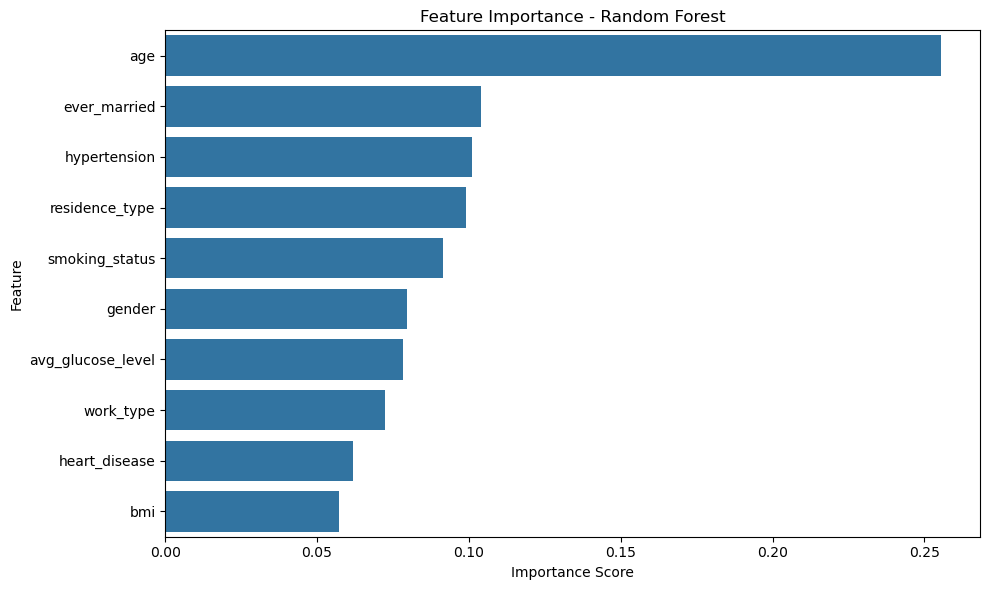

In [ ]:
rf_model = models['Random Forest']
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## CONCLUSION

**In this Project Respectively,  We have tried to a predict classification problem in Stroke Dataset by a variety of models to classify Stroke predictions in the context of determining whether anybody is likely to get Stroke based on the input parameters like gender, age and various test results or not  We have made the detailed exploratory analysis (EDA). missing values are removed in the Dataset by using Simple Imputer with Median We have decided which metrics will be used. We have analysed both target and features in detail. We have transformed categorical variables into integer by using Label Encoder, so we can use them in the models. We have examined the feature importance of some models.Lastly we have examined the results of all models visually with respect to select the best one for the problem in hand. By checking with all the scores like F1_score, Precision, Recall and Accuracy, The *Random Forest* gives the best results while comparing with other models. For Respective Dataset the *Random Forest* is the Best model for Future Predictions.**

# Prepare for Deployment

In [ ]:
import pickle

# Save the trained model
with open("RFModel.pkl", "wb") as f:
    pickle.dump(rf_model, f)